<a href="https://colab.research.google.com/github/hkaragah/risk_reliability/blob/main/PSHA_GR_Rupture_Boore1997GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSHA: Single GR Rupture Scenario with GMM Boore 1997

The considerations for this probabilistic seismic hazard analysis (PSHA) are as follows:

* Seimci source is capable of producing earthquakes with a variety of magnitudes that follows this bounded Gutenberg-Richter (GR) model:
  * $m_{min} = 5$
  * $m_{max} = 8$
  * $b = 1$
* Rate of earthauke is $\lambda(M\geq5)=0.05$ events annually
* Site is located at 10 km from this source
* The exceedance rate of an $SA(1s)$ is computed per Boore et al. 1997 groun-motion model (GMM)

## 1. Setting-up Working Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

working_dir = "/content/drive/MyDrive/Colab Notebooks/risk_reliability"
if not os.path.exists(working_dir):
  os.makedirs(working_dir)
os.chdir(working_dir)

## 2. Import Dependencies

In [8]:
import pandas as pd
from math import sqrt, log, exp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## 3. Gutenberg-Richter Distribution

The modern equivalent of the Gutenberg-Richter (GR) distribution is a boubly-bounded exponential distribution with the PDF function defined as:

$$
f_M(m) =
\begin{cases}
0, &&m<m_{min} \ \ \text{and} \ \ m>m_{max}\\
\\
\cfrac{\beta e^{-\beta (m - m_{min})}}{1-e^{-\beta (m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}
\end{cases}$$

and the CDF is defined as:

$$
F_M(m) =
\begin{cases}
0, &&m<m_{min}\\
\\
\cfrac{1-e^{-\beta(m - m_{min})}}{1-e^{-\beta(m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}\\
\\
1, &&m>m_{max}
\end{cases}$$



In [41]:
from typing import Protocol


class Magnitude(Protocol):
    @property
    def m_min(self) -> float:
        ...

    @property
    def m_max(self) -> float:
        ...

    @property
    def beta(self) -> float:
        ...

    def __str__(self) -> str:
        ...

class Gutenberg_Richter(Magnitude):

    def __init__(self, m_min:float, m_max:float, b:float):
        self._m_min = m_min
        self._m_max = m_max
        self._beta = log(10) * b


    @property
    def m_min(self) -> float:
        return self._m_min

    @property
    def m_max(self) -> float:
        return self._m_max

    @property
    def beta(self) -> float:
        return self._beta

    def probability_density_func(self, magnitudes:np.ndarray):
        pdf = self.beta * np.exp(-self.beta * (magnitudes - self.m_min)) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))
        pdf[(magnitudes < self.m_min) | (magnitudes > self.m_max)] = 0
        return pdf

    def cumulative_distribution_func(self, magnitudes:np.ndarray):
        cdf = (1 - np.exp(-self.beta * (magnitudes - self.m_min))) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))
        cdf[(magnitudes < self.m_min)] = 0
        cdf[(magnitudes > self.m_max)] = 1
        return cdf

    def probability_of_occurrence(self, magnitudes:np.ndarray) -> np.ndarray:
        midpoints = (magnitudes[:-1] + magnitudes[1:]) / 2
        mags_lower = np.pad(midpoints, (1,0), mode='constant', constant_values= magnitudes[0] - (magnitudes[1] - magnitudes[0]) / 2)
        mags_upper = np.pad(midpoints, (0,1), mode='constant', constant_values= magnitudes[-1] + (magnitudes[-1] - magnitudes[-2]) / 2)
        return self.cumulative_distribution_func(mags_upper) - self.cumulative_distribution_func(mags_lower)

    def rate_of_occurrence(self, rupture_annual_activity_rate:float, magnitudes:np.ndarray) -> np.ndarray:
        return rupture_annual_activity_rate * self.probability_of_occurrence(magnitudes)

    def rate_of_exceedance(self, rupture_annual_activity_rate:float, magnitudes:np.ndarray) -> np.ndarray:
        return np.flipud(np.flipud(self.rate_of_occurrence(rupture_annual_activity_rate, magnitudes)).cumsum())

    def __str__(self) -> str:
        return f"Gutenburg-Richter [M_min: {self.m_min}, M_max: {self.m_max}, beta: {self.beta:.2f}]"



def generate_magnitudes(m_min:float, m_max:float, step:0.01):
    return np.arange(m_min + step/2, m_max - step/2, step)

In [42]:
gr_dist = Gutenberg_Richter(m_min=5, m_max=8, b=1)

In [43]:
print(gr_dist)

Gutenburg-Richter [M_min: 5, M_max: 8, beta: 2.30]


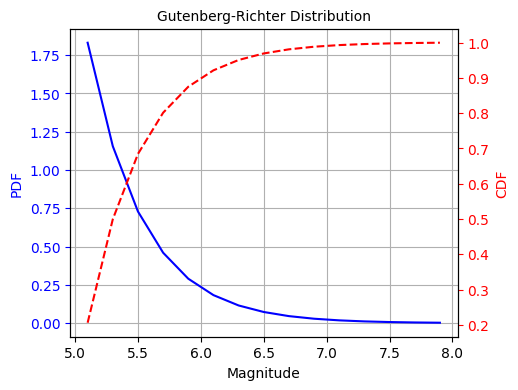

In [44]:
mags1 = generate_magnitudes(gr_dist.m_min, gr_dist.m_max, 0.2)

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(mags1, gr_dist.probability_density_func(mags1), 'b-', label="PDF")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('PDF', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(mags1, gr_dist.cumulative_distribution_func(mags1), 'r--', label="CDF")
ax2.set_ylabel('CDF', color='r')
ax2.tick_params('y', colors='r')

plt.title('Gutenberg-Richter Distribution', fontsize=10)
ax1.grid()
plt.show()

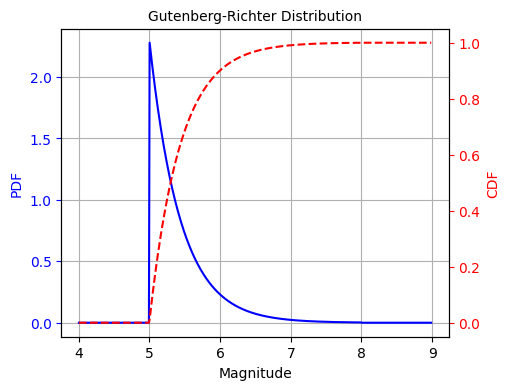

In [45]:
# Re-plot with magnitudes out of range m_min and m_max
mags2 = generate_magnitudes(4, 9, 0.01)

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(mags2, gr_dist.probability_density_func(mags2), 'b-', label="PDF")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('PDF', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(mags2, gr_dist.cumulative_distribution_func(mags2), 'r--', label="CDF")
ax2.set_ylabel('CDF', color='r')
ax2.tick_params('y', colors='r')

plt.title('Gutenberg-Richter Distribution', fontsize=10)
ax1.grid()
plt.show()

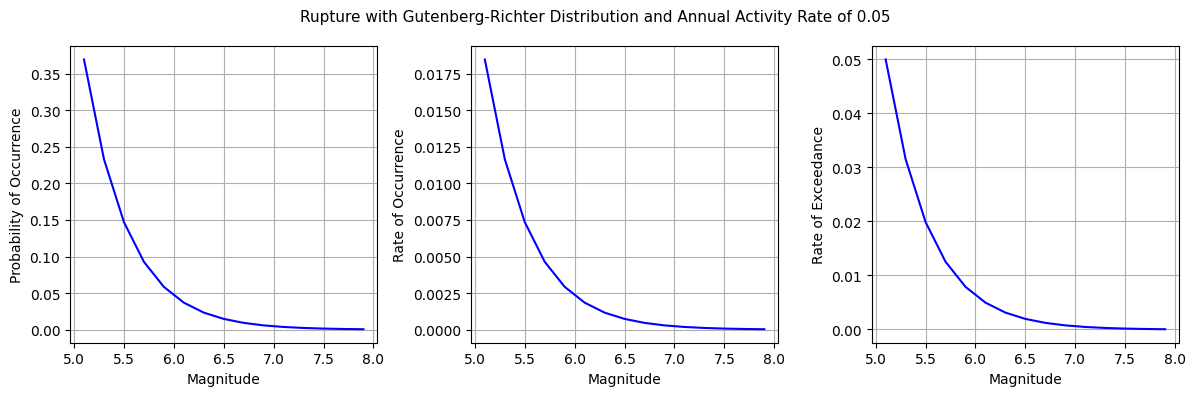

In [46]:
activity_rate = 0.05

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.lineplot(x=mags1, y=gr_dist.probability_of_occurrence(mags1), ax=axes[0], color='b')
axes[0].set_ylabel('Probability of Occurrence')

sns.lineplot(x=mags1, y=gr_dist.rate_of_occurrence(activity_rate, mags1), ax=axes[1], color='b')
axes[1].set_ylabel('Rate of Occurrence')

sns.lineplot(x=mags1, y=gr_dist.rate_of_exceedance(activity_rate, mags1), ax=axes[2], color='b')
axes[2].set_ylabel('Rate of Exceedance')

for ax in axes:
    ax.set_xlabel('Magnitude')
    ax.grid(True)

fig.suptitle(f'Rupture with Gutenberg-Richter Distribution and Annual Activity Rate of {activity_rate}', fontsize=11)
fig.tight_layout()
plt.show()

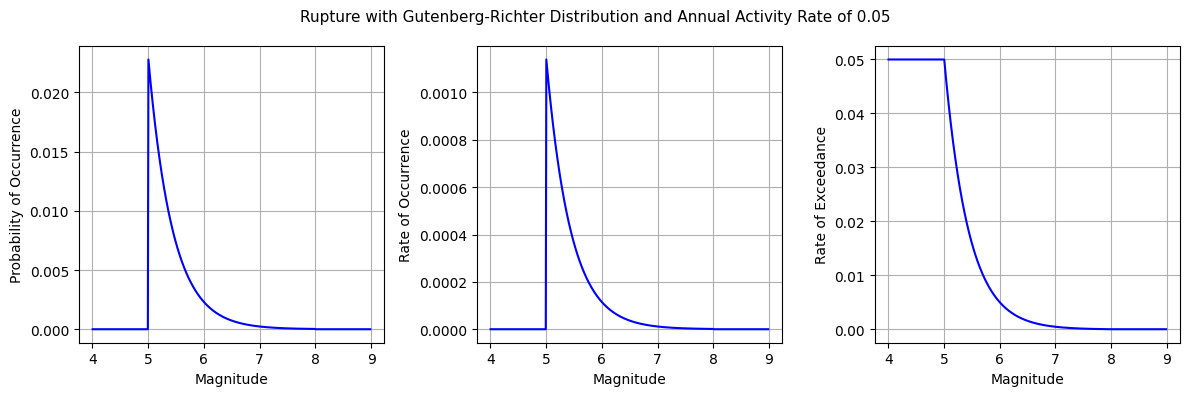

In [47]:
# Re-plot with magnitudes out of range m_min and m_max
activity_rate = 0.05

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.lineplot(x=mags2, y=gr_dist.probability_of_occurrence(mags2), ax=axes[0], color='b')
axes[0].set_ylabel('Probability of Occurrence')

sns.lineplot(x=mags2, y=gr_dist.rate_of_occurrence(activity_rate, mags2), ax=axes[1], color='b')
axes[1].set_ylabel('Rate of Occurrence')

sns.lineplot(x=mags2, y=gr_dist.rate_of_exceedance(activity_rate, mags2), ax=axes[2], color='b')
axes[2].set_ylabel('Rate of Exceedance')

for ax in axes:
    ax.set_xlabel('Magnitude')
    ax.grid(True)

fig.suptitle(f'Rupture with Gutenberg-Richter Distribution and Annual Activity Rate of {activity_rate}', fontsize=11)
fig.tight_layout()
plt.show()

## 5. Define Site and Ruptures

In [48]:
class Rupture():

    def __init__(self, rup_type:str, magnitude_dist:Magnitude, annual_activity_rate:float):
        self.rup_type = rup_type
        self.magnitude = magnitude_dist
        self.annual_activity_rate = annual_activity_rate

    def __str__(self) -> str:
        return f"{self.rup_type} rupture, rate: {self.annual_activity_rate}, {self.magnitude}"


class Site():

    def __init__(self, shear_velocity_m_sec:float):
        self.shear_velocity = shear_velocity_m_sec # Vs
        self.ruptures = []
        self.rup_dists = []

    @property
    def m_min(self):
        if len(self.ruptures) == 0:
            return None
        return np.min([rup.magnitude.m_min for rup in self.ruptures])

    @property
    def m_max(self):
        if len(self.ruptures) == 0:
            return None
        return np.max([rup.magnitude.m_max for rup in self.ruptures])

    def add_rupture(self, rupture:Rupture, distance_km:float):
        self.ruptures.append(rupture)
        self.rup_dists.append(distance_km)

    def __str__(self) -> str:
        rup_str = "\n".join([f"@ {dist}km -> {rup}" for rup, dist in zip(self.ruptures, self.rup_dists)])
        return f"Site: Vs {self.shear_velocity}\nRuptures:\n{rup_str if rup_str else 'None'}"

In [153]:
gr_dist1 = Gutenberg_Richter(m_min=5, m_max=8, b=1)
gr_dist2 = Gutenberg_Richter(m_min=5.5, m_max=8, b=1)
dist_km = 10

rup1 = Rupture(rup_type="strike-slip", magnitude_dist=gr_dist1, annual_activity_rate = 0.05)
rup2 = Rupture(rup_type="strike-slip", magnitude_dist=gr_dist2, annual_activity_rate = 0.01)


site1 = Site(shear_velocity_m_sec = 500)

site1.add_rupture(rup1, 10)
# site1.add_rupture(rup2, 15)

print(site1)

Site: Vs 500
Ruptures:
@ 10km -> strike-slip rupture, rate: 0.05, Gutenburg-Richter [M_min: 5, M_max: 8, beta: 2.30]


## 4. Boore et al. (1997) Ground-Motion Model (GMM)

1- __Reference__

David M. Boore, William B. Joyner, and Thomas E. Fumal, 1997, Equations for Estimating Horizontal Response Spectra and Peak Acceleration from Western North American Earethquakes: A Summary of recent Work, Seismological Research Letters, Vol. 68, No. 1, 128-153.

2- __Estimated physical parameter__

  - Peak ground acceleration (Horizontal)
  - Spectral acceleration (h=5%, T=0.1 to 2 sec) (Horizontal)



3- __Used strong motion data__

  - Area: Western North America
  - Type of earthquake: Shallow earthquake (which the fault rupture lies mainly above a depth of  20km)
  - Period: 1940 – 1992 years
  - Number of events: 19
  - Number of records: 271
  - Magnitude: 5.2 – 7.4
  - Epicentral distance: 0 – 118 km

4- __Style of faulting__

  - Strike-slip
  - Reverse-slip
  - Mechanism is not specified

5- __Ground condition__

Classified by the average S-wave velocity over 30 m from ground surface

6- __Definition of magnitude__

Moment magnitude

7- __Definition of source distance__

Closest horizontal distance to a point on the earth's surface that lies directly above the rupture.

8- __Definition of horizontal component__

Random horizontal component

9- __Applicability written in the paper__

The equations are to be used magnitude 5.5 - 7.5 and distance no greater than 80 km.

10- __Empirical attenuation formula__

$$\ln Y = b_1 + b_2(M-6) + b_3(M-6)^2 + b_5 \ln r + b_V \ln \frac{V_S}{V_A}$$

* $r=\sqrt{r_{jb}^2 + h^2}$

* $b_1 =
\begin{cases}
b_{1SS} &\text{for strike-slip earquake s}\\
b_{1RV} &\text{for reverse-slip earthquake s}\\
b_{1ALL} &\text{if mechanism not specified}
\end{cases}$

* $Y$: peak horizontal acceleration or pseudo acceleration response (g)

* $M$: moment magnitude

* $r_{jb}$: closest horizontal distance to the surface projection of the rupture plane (km)

* $V_S$: average shear wave velocity to 30 m (m/sec)

Standard Error:
* $\sigma_{\ln Y}^2 = \sigma_Y^2 + \sigma_e^2$
* $\sigma_{\ln Y}$: one-sigma value of the natural logarithm of the ground-motion value
* $\sigma_e^2$: earthquake-to-earthquake component of variability
* $\sigma_r^2$: all other components of variability
* $\sigma_r^2 = \sigma_1^2 + \sigma_c^2$
* $\sigma_1^2$: variance from the first stage of regression
* $\sigma_c^2$: correction needed to give the variance corresponding to the randomly-oriented horizontal component

<a href="https://iisee.kenken.go.jp/eqflow/reference/1_2.htm">Boore et al 1997 coefficients</a>

In [123]:
class Ground_Motion_Model(Protocol):
    def load_data(self, **kwargs) -> pd.DataFrame:
        ...

    @property
    def periods(self) -> np.ndarray:
        ...

    def median(self, shear_velocity_m_sec:float, magnitudes:np.ndarray, rup_type:str, dist_km:float)->np.ndarray:
        ...

    def standard_deviation(self)->np.ndarray:
        ...

class Boore_1997(Ground_Motion_Model):

    def __init__(self) -> None:
        """
          Boore et al. 1997 coefficients
          Reference: https://iisee.kenken.go.jp/eqflow/reference/1_2.htm
        """
        self.df: pd.DataFrame = self.load_data()


    def load_data(self, path:str='Boore_et_al_1997.csv', index_col:str='Period')->pd.DataFrame:
        """Load GMM data from CSV."""
        df = pd.read_csv(path, header=0, index_col=index_col)
        df.drop([0], axis=0, inplace=True)
        df.index.name = index_col
        return df

    @property
    def periods(self)->np.ndarray:
        return self.df.index.values

    def median(self, shear_velocity_m_sec:float, magnitudes:np.ndarray, rup_type:str, dist_km:float)->np.ndarray:

        m = magnitudes.reshape(1,-1)
        r = np.sqrt(dist_km**2 + self.df['h']**2).to_numpy().reshape(-1,1)

        b2 = self.df['B2'].to_numpy().reshape(-1,1)
        b3 = self.df['B3'].to_numpy().reshape(-1,1)
        b5 = self.df['B5'].to_numpy().reshape(-1,1)
        bv = self.df['BV'].to_numpy().reshape(-1,1)
        va = self.df['VA'].to_numpy().reshape(-1,1)

        if rup_type.lower() == 'strike-slip':
            b1 = self.df['B1SS'].to_numpy().reshape(-1,1)
        elif rup_type.lower() == 'reverse-slip':
            b1 = self.df['B1RV'].to_numpy().reshape(-1,1)
        else:
            b1 = self.df['B1ALL'].to_numpy().reshape(-1,1)

        return np.exp(b1 + b2*(m-6) + b3*(m-6)**2 + b5*np.log(r) + bv*np.log(shear_velocity_m_sec/va))

    def standard_deviation(self)->np.ndarray:
        return self.df['slnY'].to_numpy()

In [124]:
gmm = Boore_1997()

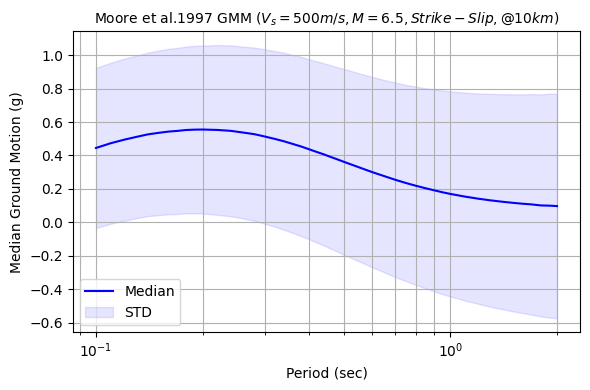

In [54]:
mag = mags1[np.argmin(np.abs(mags1-6.5))]

medians = gmm.median(shear_velocity_m_sec=site1.shear_velocity, magnitudes=mag, rup_type='strike-slip', dist_km=10)
stds = gmm.standard_deviation()

plt.figure(figsize=(6,4))
sns.lineplot(x=gmm.periods, y=medians.ravel(), color='b', label='Median')
plt.fill_between(gmm.periods, medians.ravel()-stds, medians.ravel()+stds, color='b', alpha=0.1, label="STD")
plt.xscale('log')
plt.xlabel('Period (sec)')
plt.ylabel('Median Ground Motion (g)')
plt.title(fr'Moore et al.1997 GMM ($V_s=500 m/s, M={mag:.1f}, Strike-Slip, @10 km$)', fontsize=10)
plt.legend(loc='lower left')
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [102]:
def probability_of_exceedance(site:Site, spectral_accelerations:np.ndarray, magnitudes:np.ndarray, gmm:Ground_Motion_Model):
    probabilities = np.zeros((len(gmm.periods), len(magnitudes),len(spectral_accelerations),len(site.ruptures)))
    for i in range(len(site.ruptures)):
        rup = site.ruptures[i]
        dist = site.rup_dists[i]
        proba = np.zeros((len(gmm.periods), len(magnitudes),len(spectral_accelerations)))
        medians = gmm.median(site.shear_velocity, magnitudes, rup.rup_type, dist).reshape(len(gmm.periods),-1,1)
        stds = gmm.standard_deviation().reshape(len(gmm.periods),1,1)
        probabilities[:,:,:,i] = 1 - norm.cdf(np.log(spectral_accelerations), loc=np.log(medians), scale=0.52)#stds)
    return probabilities



def annual_rate_of_exceedance(site:Site, probability_of_exceedance:np.ndarray, magnitudes:np.ndarray, sum_magnitudes=False, sum_ruptures=False):
    rates = np.zeros(probability_of_exceedance.shape)
    for i in range(len(site.ruptures)):
        rup = site.ruptures[i]
        rates[:,:,:,i] = probability_of_exceedance[:,:,:,i] * rup.magnitude.rate_of_occurrence(rup.annual_activity_rate, magnitudes).reshape(1,-1,1)

    if sum_ruptures:
        rates = np.sum(rates, axis=3)

    if sum_magnitudes:
        rates = np.sum(rates, axis=1)

    return rates





In [154]:
spect_acc = np.linspace(5e-2, 2, 100) # SA

proba = probability_of_exceedance(site1, spect_acc, mags1, gmm)
rates = annual_rate_of_exceedance(site1, proba, mags1, sum_magnitudes=True, sum_ruptures=True)

print(rates.shape)

(46, 100)


In [155]:
def compute_rate_at(target_sa:np.ndarray, period_index:int):
    proba = probability_of_exceedance(site1, target_sa, mags1, gmm)
    rate = annual_rate_of_exceedance(site1, proba, mags1, sum_magnitudes=True, sum_ruptures=True)
    return rate[period_index]


def add_annotation_at(target_sa:float, period_index:int, show_rate:bool=False):
    rate = compute_rate_at(np.array([target_sa]), period_index)[0]
    plt.plot(target_sa, rate, marker='o',markerfacecolor='none', markeredgecolor='black')
    if show_rate:
        plt.annotate(fr"$\lambda (SA(1s)>{target_sa}g) = {rate:.5f}$",
                     xy=(target_sa+2e-2, rate), xycoords='data', va='bottom', ha='left', fontsize=9)

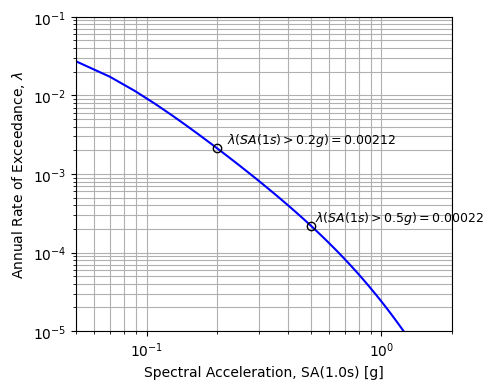

In [156]:
period = 1.0 # sec
period_index = np.argmin(np.abs(gmm.periods-period))
rates_to_plot = rates[period_index,:]

plt.figure(figsize=(5,4))
sns.lineplot(x=spect_acc, y=rates_to_plot, color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlim(min(spect_acc), max(spect_acc))
plt.ylim(1e-5, 0.1)
plt.xlabel(f'Spectral Acceleration, SA({period}s) [g]')
plt.ylabel(r'Annual Rate of Exceedance, $\lambda$')

for sa in [0.2, 0.5]:
    add_annotation_at(sa, period_index, show_rate=True)


plt.grid(which='both')
plt.tight_layout()
plt.show()